### Walgreen Stock Price Prediction

In [72]:
## import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

**1. Loading the data from walgreen_data.csv file**

In [73]:
df = pd.read_csv('Walgreen_Stock.csv')

In [74]:
df.shape

(10468, 7)

In [75]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


**2. Data Preprocessing**

In [77]:
## Finding Null values
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


In [79]:
## Converting the date column into datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10468 non-null  datetime64[ns]
 1   Open       10468 non-null  float64       
 2   High       10468 non-null  float64       
 3   Low        10468 non-null  float64       
 4   Close      10468 non-null  float64       
 5   Adj Close  10468 non-null  float64       
 6   Volume     10468 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 572.6 KB


In [81]:
## making date column as index
df.set_index('Date', inplace=True)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10468 entries, 1980-12-12 to 2022-06-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10468 non-null  float64
 1   High       10468 non-null  float64
 2   Low        10468 non-null  float64
 3   Close      10468 non-null  float64
 4   Adj Close  10468 non-null  float64
 5   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 572.5 KB


In [83]:
df.drop(df[df.index < pd.to_datetime('2018-08-15')].index, inplace=True)

In [84]:
df.shape

(968, 6)

In [85]:
## converting sequential data by sorting based on date
df = df.sort_index()

In [86]:
## Data Normalization 
scaler = MinMaxScaler()
scaler_values = scaler.fit_transform(df[df.columns])

In [87]:
scaler_values

array([[0.11122856, 0.11094806, 0.11546094, 0.11615602, 0.11076474,
        0.19255117],
       [0.11554199, 0.1161866 , 0.12092676, 0.12141334, 0.11581483,
        0.1893637 ],
       [0.1184233 , 0.12325096, 0.12386855, 0.12868482, 0.12279981,
        0.26123317],
       ...,
       [0.67033785, 0.68875841, 0.67302609, 0.68196635, 0.68672669,
        0.13108091],
       [0.65526647, 0.65497234, 0.65130202, 0.6453017 , 0.65022031,
        0.17411714],
       [0.641559  , 0.65968194, 0.65666343, 0.65554323, 0.66041764,
        0.24154626]], shape=(968, 6))

In [90]:
## the above normalized values are in numpy array format, converting them into dataframe
df_scaled = pd.DataFrame(scaler_values, columns=df.columns, index=df.index)
df_scaled.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-15,0.111229,0.110948,0.115461,0.116156,0.110765,0.192551
2018-08-16,0.115542,0.116187,0.120927,0.121413,0.115815,0.189364
2018-08-17,0.118423,0.123251,0.123869,0.128685,0.122800,0.261233
2018-08-20,0.126368,0.125350,0.127263,0.125066,0.119324,0.207908
2018-08-21,0.124152,0.121954,0.125383,0.124349,0.118635,0.165078


**3. Plotting the Columns**

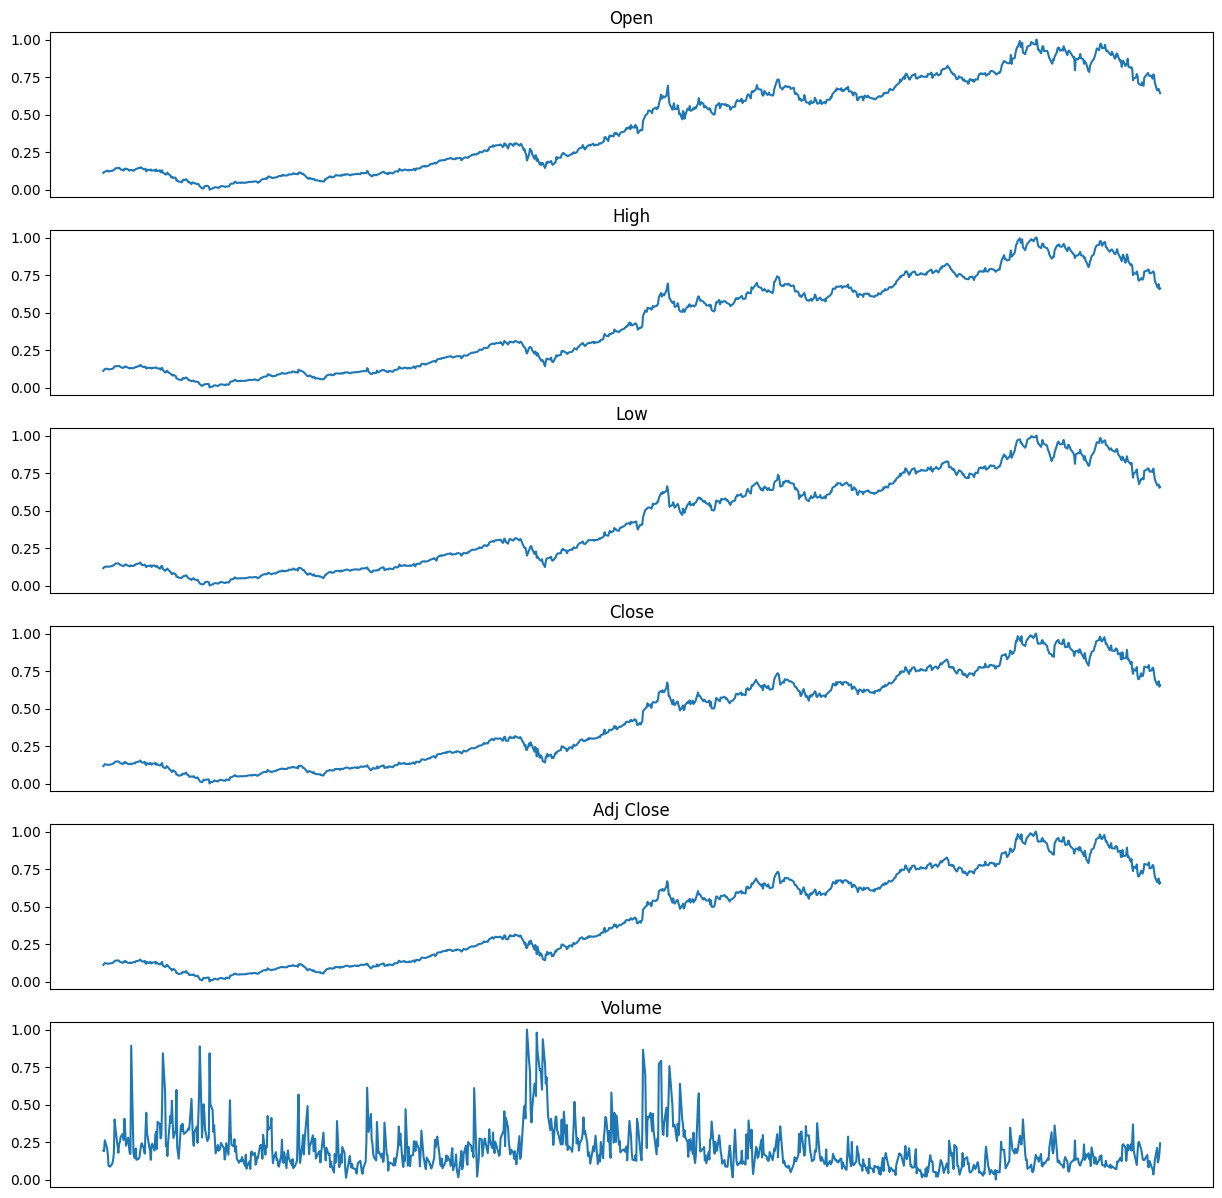

In [92]:
plt.rcParams['figure.figsize'] = (15,15)
figure, axes = plt.subplots(6)

for ax, col in zip(axes, df_scaled.columns):
    ax.plot(df_scaled[col])
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)

**4. Creating the sliding window sequences**

In [49]:
## [1,2,3,4.... 10]
# window_size = 3
# [1,2,3] => [4]
# [2,3,4] => [5]
# [3,4,5] => [6]

In [ ]:
def create_sequence(data,window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(x), np.array(y)

In [64]:
X, y = create_sequence(df_scaled, window_size=60)

In [65]:
X.shape, y.shape

((908, 60, 6), (908, 6))

**5. Train - Test Split**

In [67]:
X_train,X_text,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape, X_text.shape, y_train.shape, y_test.shape

((726, 60, 6), (182, 60, 6), (726, 6), (182, 6))

**6. Building LSTM model**

In [71]:
import pandas as pd
import numpy as np

# Example data
data = pd.DataFrame({'value': [1, 2, 3, 4, 5, 6]})
window_size = 3

def create_sequence(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        print(i, i-window_size)
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(X), np.array(y)

X, y = create_sequence(data, window_size)

print("X:\n", X)
print("y:\n", y)


3 0
4 1
5 2
X:
 [[[1]
  [2]
  [3]]

 [[2]
  [3]
  [4]]

 [[3]
  [4]
  [5]]]
y:
 [[4]
 [5]
 [6]]
